# Sistem Retrieval Augmented Generation (RAG) untuk Identifikasi Hewan dan Deskripsi Visual Menggunakan Dataset Oxford-IIIT Pets

In [ ]:
!pip install datasets faiss-cpu pillow tqdm transformers torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 61.3 MB/s eta 0:00:00


In [ ]:
# Cell 2: Imports
import re
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import faiss
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn.functional as F
from transformers import (
    CLIPProcessor, CLIPModel,
    Blip2Processor, Blip2ForConditionalGeneration,
    T5Tokenizer, T5ForConditionalGeneration
)



In [ ]:
# Colab drive mount
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

Mounted at /content/drive


In [ ]:
# Cell 3: Dataset
DATASET_DIR = "drive/MyDrive/Dataset/archive/images"
# gunakan sorted agar urutan deterministik dan konsisten
image_paths = sorted(list(Path(DATASET_DIR).glob("*.jpg")))
print("Total images:", len(image_paths))
print("Contoh 5 path:", image_paths[:5])

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32
print("Device:", device, "dtype:", dtype)

Total images: 7390
Contoh 5 path: [PosixPath('drive/MyDrive/Dataset/archive/images/Abyssinian_1.jpg'), PosixPath('drive/MyDrive/Dataset/archive/images/Abyssinian_10.jpg'), PosixPath('drive/MyDrive/Dataset/archive/images/Abyssinian_100.jpg'), PosixPath('drive/MyDrive/Dataset/archive/images/Abyssinian_101.jpg'), PosixPath('drive/MyDrive/Dataset/archive/images/Abyssinian_102.jpg')]
Device: cuda dtype: torch.float16


In [ ]:
# Cell 4: Load CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype).to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# Cell 5: Build embeddings & clean labels
image_embeddings = []
raw_labels = []

for img_path in tqdm(image_paths, desc="Embedding images"):
    image = Image.open(img_path).convert("RGB")

    inputs = clip_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # get_image_features -> tensor shape (1, D)
        embedding = clip_model.get_image_features(**inputs)  # shape (1, D)
        # normalisasi per-vektor
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)

    # simpan embedding
    image_embeddings.append(embedding.cpu().numpy())  # shape (1, D)
    raw_labels.append(img_path.stem)

# gabungkan jadi array (N, D)
image_embeddings = np.concatenate(image_embeddings, axis=0).astype("float32")

# Clean labels: perbaikan regex untuk hapus numeric suffix di akhir
def clean_label(raw):
    stem = str(raw)
    # ambil stem jika path diberikan
    stem = Path(stem).stem
    # hapus trailing angka atau (1) atau -1 atau _1 di akhir
    stem = re.sub(r'[_\-\s]*(\(\d+\)|\d+)$', '', stem)
    # ganti underscore/hyphen -> spasi, lalu title case
    stem = re.sub(r'[_\-]+', ' ', stem).strip().title()
    return stem

labels = np.array([clean_label(r) for r in raw_labels], dtype=object)

# Save embeddings, cleaned labels, image paths
np.save("embeddings.npy", image_embeddings)
np.save("labels_clean.npy", labels)
np.save("image_paths.npy", np.array([str(p) for p in image_paths]))
print("Saved embeddings, cleaned labels, and image paths.")
print("Embeddings shape:", image_embeddings.shape)
print("Labels sample:", labels[:10])

Embedding images: 100%|██████████| 7390/7390 [06:09<00:00, 20.02it/s]


Saved embeddings, cleaned labels, and image paths.
Embeddings shape: (7390, 768)
Labels sample: ['Abyssinian' 'Abyssinian' 'Abyssinian' 'Abyssinian' 'Abyssinian'
 'Abyssinian' 'Abyssinian' 'Abyssinian' 'Abyssinian' 'Abyssinian']


In [ ]:
# Cell 6: Build FAISS index
# faiss.normalize_L2 lakukan lagi untuk safety
faiss.normalize_L2(image_embeddings)
dimension = image_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(image_embeddings)
print("Total indexed vectors:", index.ntotal)

def search_similar(img, k=5):
    inputs = clip_processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        q_vec = clip_model.get_image_features(**inputs)  # (1, D)
        q_vec = q_vec / q_vec.norm(dim=-1, keepdim=True)
        q_vec = q_vec.cpu().numpy().astype("float32")
    faiss.normalize_L2(q_vec)
    distances, indices = index.search(q_vec, k)
    return distances, indices

# Dominant breed
def get_dominant_breed(indices):
    # pastikan indices 1D
    if isinstance(indices, np.ndarray) and indices.ndim > 1:
        indices = indices[0]
    retrieved = [labels[i] for i in indices]
    breed, count = Counter(retrieved).most_common(1)[0]
    confidence = count / len(retrieved)
    return breed, confidence

# Save FAISS index
faiss.write_index(index, "faiss.index")
print("Saved FAISS index. Total indexed vectors:", index.ntotal)

Total indexed vectors: 7390
Saved FAISS index. Total indexed vectors: 7390


In [ ]:
# Cell 7: Load BLIP-2 & T5
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl", torch_dtype=dtype
).to(device)

t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained(
    "google/flan-t5-large", torch_dtype=dtype
).to(device)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.81G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Cell 8: BLIP caption
def generate_visual_caption(img):
    inputs = blip_processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_new_tokens=40)
    try:
        return blip_processor.decode(out[0], skip_special_tokens=True)
    except Exception:
        return t5_tokenizer.decode(out[0], skip_special_tokens=True)

# T5 narration
def generate_final_narration(breed, confidence, visual_caption):
    """
    Deskripsi deterministik + jujur.
    TIDAK bisa gagal, TIDAK bisa echo.
    """

    # Kalimat 1: ciri fisik umum
    desc1 = (
        f"The {breed} typically has a short, dense coat and a slender body shape."
    )

    # Kalimat 2: evidensi & keterbatasan
    if confidence < 0.85:
        desc2 = (
            "The identification is based on visual similarity to reference images, "
            "as the image does not show distinctive breed-specific features."
        )
    else:
        desc2 = (
            "The identification is supported by strong visual similarity to retrieved reference images."
        )

    # Kalimat 3: temperamen umum
    desc3 = (
        f"This breed is generally known for a calm and reserved temperament."
    )

    base_text = f"{desc1} {desc2} {desc3}"

    return base_text
def refine_with_flan_t5(text):
    prompt = f"""
Rewrite the following text to be clear and natural.
Do NOT add new information.
Do NOT remove facts.

Text:
{text}
"""
    inputs = t5_tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = t5_model.generate(
            **inputs,
            max_new_tokens=120,
            num_beams=4,
            no_repeat_ngram_size=3
        )

    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)




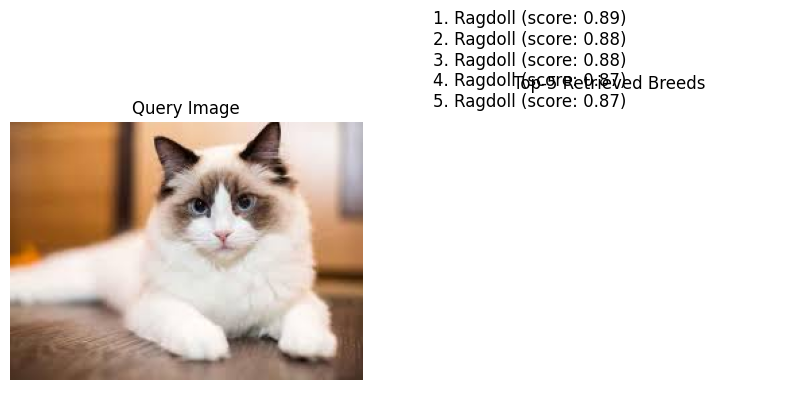

=== FINAL RESULT ===
Predicted Breed: Ragdoll
Confidence: 100%

Visual Caption: a sammy cat laying on a wooden floor

Generated Description:
 The Ragdoll typically has a short, dense coat and a slender body shape. The identification is supported by strong visual similarity to retrieved reference images. This breed is generally known for a calm and reserved temperament.


In [ ]:
# Cell 9: Test retrieval & generation
query_path = "cat_2.jpg"  # ganti ke path yang ada, atau gunakan full path di drive
query_img = Image.open(query_path).convert("RGB")

# Search
distances, indices = search_similar(query_img, k=5)

# Dominant breed
breed, confidence = get_dominant_breed(indices)

# Visual caption
visual_caption = generate_visual_caption(query_img)

# Final narration
base_text = generate_final_narration(
    breed,
    confidence,
    visual_caption
)

# opsional: haluskan bahasa
final_text = refine_with_flan_t5(base_text)



# Flatten indices & distances untuk visualisasi
indices_1d = indices.flatten()
distances_1d = distances.flatten()

# Visualization
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(query_img)
plt.title("Query Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Top-5 Retrieved Breeds")

text = ""
for i, idx in enumerate(indices_1d):
    text += f"{i+1}. {labels[idx]} (score: {distances_1d[i]:.2f})\n"

plt.text(0, 0.9, text, fontsize=12)
plt.show()

# Print results
print("=== FINAL RESULT ===")
print("Predicted Breed:", breed)
print(f"Confidence: {confidence*100:.0f}%")
print("\nVisual Caption:", visual_caption)
print("\nGenerated Description:\n", final_text)
